In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.Original_frbprojection_code import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)


# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

foggie_dir = "/Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/"
# code_path should be the path to the directory where you've cloned the github repo.
code_path = "/Users/hylee/coding/foggie/foggie/"

# Finally, this is the name of the simulation output.
foggie_dir_output = "/Users/hylee/foggie/foggie_output/halo_008508/nref11c_nref9f/"
foggie_sim = "/Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/"
github_dir = "/Users/hylee/coding/foggie/foggie/" 
snap = "RD0042"
foggie_output = '/Users/hylee/foggie/foggie_output/halo_008508/nref11c_nref9f/'
track_dir = github_dir + 'halo_infos/008508/nref11c_nref9f/'
track_name = github_dir + 'halo_tracks/008508/nref11n_selfshield_15/halo_track_200kpc_nref9'
snap_name = foggie_sim + snap + '/' + snap

In [2]:
field = "density"
axis = "y" 
width = 200 #[kpc]
resolution = 70 #[pixel]
colorlabel = 'Density [log 10 g/cm^3]'
max_radius = width/2 #[kpc]
min_radius = 0  #[kpc]
binsize = 1.5 #[kpc]

In [3]:
#Defining function that converts each pixel into radius from galactic center by indexing /func1 

def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
            
    return OD_Rad, OD_Qua

In [4]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [5]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [6]:
ds, refine_box = foggie_load(snap_name, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                             disk_relative=False, do_filter_particles=False, masses_dir=track_dir)

Opening snapshot /Users/hylee/foggie/foggie_sims/halo_008508/nref11c_nref9f/RD0042/RD0042


yt : [INFO     ] 2023-07-07 16:05:06,007 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-07-07 16:05:06,008 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-07 16:05:06,009 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-07 16:05:06,010 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-07 16:05:06,011 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-07 16:05:06,012 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-07-07 16:05:06,013 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-07 16:05:06,013 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-07 16:05:06,014 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-07 16:05:06,015 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4251/4251 [00:00<00:00, 9312.00it/s]
yt : [INFO     ] 2023-07-07 16:05:06,674 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


In [7]:
frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)

# How to tell which axis is y / z ? => By proj.plot()

yt : [INFO     ] 2023-07-07 16:05:10,571 Projection completed


In [8]:
OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

yt : [INFO     ] 2023-07-07 16:05:10,577 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


In [9]:
radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)

In [10]:
p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist))
xd = radiuslist
#plt.plot(xd, piecewise_linear(xd, *p)) #Plotting piecewise function

my_pwlf = pwlf.PiecewiseLinFit(radiuslist, np.log10(quantitylist))
breaks = my_pwlf.fit(2) #2 segments for this plot 
#print(breaks)#Prints the non-continuous point

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


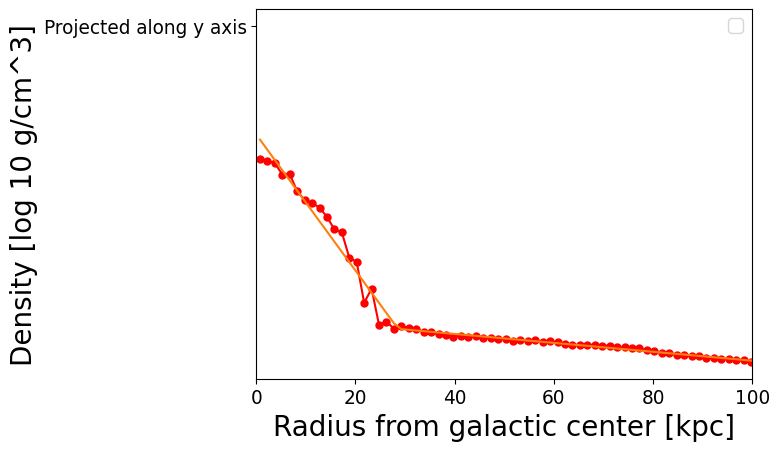

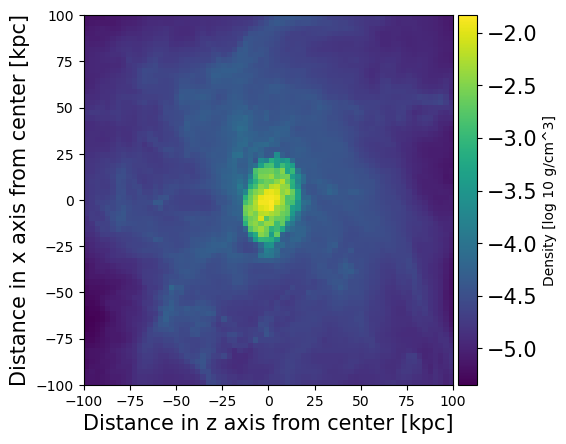

In [11]:
#Part I am trying to make into a function 

markersize = 10
fontsize = 20 
    
# Make the part below as a function?
def plotting(xvalue, yvalue, color, plotlabel, segx, segy):
    lineplot = plt.plot(xvalue, yvalue, color, plotlabel)
    dotplot = plt.plot(xvalue, yvalue,'ro',markersize=markersize/2)
    segplot = plt.plot(xd, piecewise_linear(xd, *p))
    return lineplot, dotplot, segplot
def labellegend(xtext, ytext):
    legend = plt.legend(loc="upper right", fontsize = fontsize/1.5)
    xtxt = plt.xlabel(xtext, fontsize = fontsize)
    ytxt = plt.ylabel(ytext, fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    plt.xlim([min_radius, max_radius])
    return legend, xtxt, ytxt
    
lineplot, dotplot, segplot = plotting(radiuslist, np.log10(quantitylist), "r-",'Projected along y axis',xd,
                                    piecewise_linear(xd, *p))

legend, xtx, ytxt = labellegend("Radius from galactic center [kpc]","Density [log 10 g/cm^3]")

fig = projection(frb, field, width, colorlabel, axis, fontsize = 15)


[ 0.75       28.57092624 99.75      ]


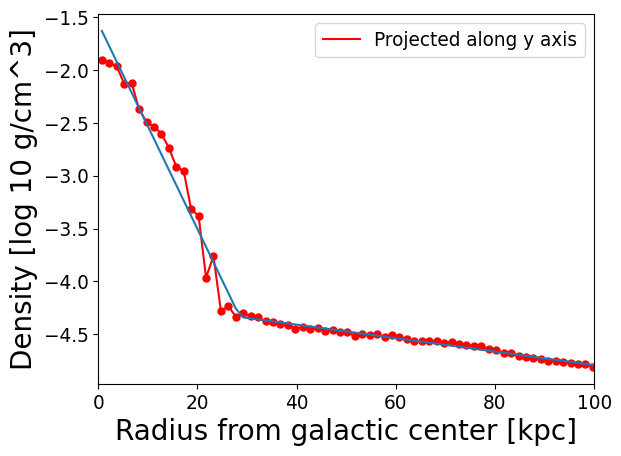

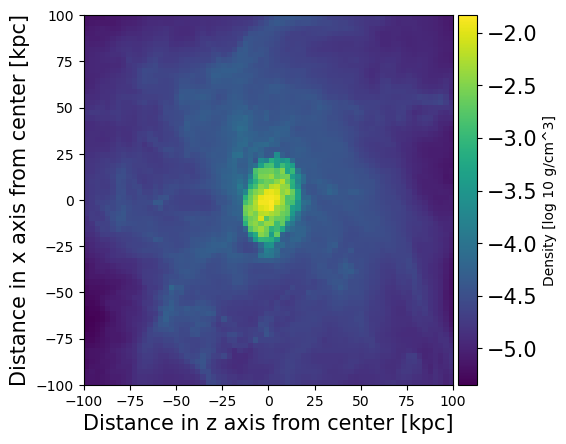

In [12]:
#Original plotting part     
    
#Plotting metallicity gradient in x,y,z axis with proper labeling and legend

markersize = 10
fontsize = 20 
    
print(breaks)
#plt.plot(radiuslist, np.log10(quantitylist), 'g-', label = 'Projected along x axis') 
#plt.plot(radiuslist, np.log10(quantitylist),'go', markersize=markersize/2)
plt.plot(radiuslist, np.log10(quantitylist), 'r-',label = 'Projected along y axis')
plt.plot(radiuslist, np.log10(quantitylist),'ro',markersize=markersize/2)
plt.plot(xd, piecewise_linear(xd, *p))
#plt.plot(radiuslist, np.log10(quantitylist)), 'b-',label = 'Projected along z axis')
#plt.plot(radiuslist, np.log10(quantitylist)),'bo', markersize=markersize/2)
plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
plt.ylabel("Density [log 10 g/cm^3]", fontsize = fontsize)
plt.legend(loc="upper right", fontsize = fontsize/1.5)
plt.xticks(fontsize = fontsize/1.5)
plt.yticks(fontsize = fontsize/1.5)
plt.xlim([min_radius, max_radius])


fig = projection(frb, field, width, colorlabel, axis, fontsize = 15)



#plt.ylim(-1.3, 0.4) #Set the ylim to be -1.3-0.4
#plt.show()
# plt.savefig(foggie_output + 'RD0042_Density_Profile.jpg')  # => Figure saving directory + file name / size?

#goal : fit a data into 2 linear line. 

In [13]:
print(len(radiuslist))

67
